# Importação das bibliotecas necessárias

In [112]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from pandas_profiling import ProfileReport
from unidecode import unidecode

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_roc_curve
# from skopt import BayesSearchCV

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import lime


# Criação de dataset

In [20]:
# Dataset principal
df = pd.read_excel('../data/carteira_total.xlsx')


In [21]:
df.head()


,mÊs,ID CRM,ID NAVPLAT,ID SAP,REGIÃO,CIDADE,BAIRRO,VALOR MENSAL,VALOR HOJE,UPSALE/DOWNSALE,...,LEADS FORM,LEADS VER DATO,LEADS TOTAL,Custo por lead total,Total Contratado,TOTAL DE LISTINGS,CUSTO POR LISTING,PF/PJ,Total Utilizado,Faixa Listings
0,2020-01-01,10400005,10400005,2000340391,DF,SOBRADINHO,Sobradinho,434.40,434.40,ok,...,21.0,100.0,121.0,3.590083,50.0,9,48.266667,PJ,9.0,6 – 10
1,2020-01-01,10400007,10400007,2000340644,DF,BRASÍLIA,Asa Sul,312.00,312.00,ok,...,18.0,106.0,124.0,2.516129,25.0,7,44.571429,PF,7.0,6 – 10
2,2020-01-01,10400014,10400014,2000254856,DF,BRASÍLIA,Asa Sul,1798.80,1798.80,ok,...,174.0,520.0,694.0,2.591931,10031.0,67,26.847761,PJ,67.0,61 – 100
3,2020-01-01,10400015,10400015,2000254860,DF,BRASÍLIA,Setor de Habitações Individuais Sul,3958.00,3958.00,ok,...,126.0,305.0,431.0,9.183295,10060.0,144,27.486111,PJ,144.0,101 – 200
4,2020-01-01,10400022,10400022,2000339394,DF,TAGUATINGA,Taguatinga Norte (Taguatinga),565.13,565.13,ok,...,20.0,113.0,133.0,4.249098,200.0,31,18.230000,PJ,31.0,31 – 40


# Pandas Proffling

In [22]:
# prof = ProfileReport(df)
# prof.to_file(output_file='output.html')

# EDA

Remoção dos acentos das colunas e alteração dos caracteres diferentes de alfa numérico para "_"

In [23]:
newColumnsName = []
for column_name in df:
  newColumnsName.append(re.sub('[^A-Za-z0-9]+', '_', unidecode(column_name).lower()))
df.columns = newColumnsName

Criação da coluna churn, e definição do seu valor com base nos valores da coluna upsale_downsale (churn = 1, demais valores = 0). Decidimos excluir a coluna upsell_downsell (por não ter mais importância para a análise)

In [24]:
df["upsale_downsale"].replace({"Churn": "churn", "Upsell": "upsell", "Downsell": "downsell", "Ok": "ok"}, inplace=True)
df['churn'] = df['upsale_downsale']
df['churn'].replace({"ok": "0", "upsell": "0", "downsell": "0", "churn": "1"}, inplace=True)
df['churn'] = df['churn'].astype(int)

df.drop(columns = ["upsale_downsale"], inplace = True)

In [25]:
df.head()

,mes,id_crm,id_navplat,id_sap,regiao,cidade,bairro,valor_mensal,valor_hoje,faturamento,...,leads_ver_dato,leads_total,custo_por_lead_total,total_contratado,total_de_listings,custo_por_listing,pf_pj,total_utilizado,faixa_listings,churn
0,2020-01-01,10400005,10400005,2000340391,DF,SOBRADINHO,Sobradinho,434.40,434.40,434.0,...,100.0,121.0,3.590083,50.0,9,48.266667,PJ,9.0,6 – 10,0
1,2020-01-01,10400007,10400007,2000340644,DF,BRASÍLIA,Asa Sul,312.00,312.00,312.0,...,106.0,124.0,2.516129,25.0,7,44.571429,PF,7.0,6 – 10,0
2,2020-01-01,10400014,10400014,2000254856,DF,BRASÍLIA,Asa Sul,1798.80,1798.80,1799.0,...,520.0,694.0,2.591931,10031.0,67,26.847761,PJ,67.0,61 – 100,0
3,2020-01-01,10400015,10400015,2000254860,DF,BRASÍLIA,Setor de Habitações Individuais Sul,3958.00,3958.00,3958.0,...,305.0,431.0,9.183295,10060.0,144,27.486111,PJ,144.0,101 – 200,0
4,2020-01-01,10400022,10400022,2000339394,DF,TAGUATINGA,Taguatinga Norte (Taguatinga),565.13,565.13,565.0,...,113.0,133.0,4.249098,200.0,31,18.230000,PJ,31.0,31 – 40,0


In [26]:
# Missing Values
# contratado_freemium (52.1%) - Quantidade de zeros (25.9%)
# utilizado_freemium (52.1%) - Quantidade de zeros (44.5%)

# possui_midia_ativa_ (0.6%) - categorica
# custo_por_lead_total (0.4%)
# total_contratado (0.4%)
# utilizado_super_destaques (< 0.1%)
# utilizado_destaque (< 0.1%)
# utilizado_ofertas_simples (< 0.1%)
# leads_form (< 0.1%)
# leads_ver_dato (< 0.1%)
# leads_total (< 0.1%)
# custo_por_listing (< 0.1%)
# total_utilizado (< 0.1%)
# faixa_listings (< 0.1%) - categorica

## Padronizando valores categóricos

### Oficina

In [27]:
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

In [28]:
df['oficina'].replace({'wi': 'WI'}, inplace=True) # Alterando o valor wi para igualar a WI
df['oficina'].unique()

array(['WI', 'IW'], dtype=object)

### Faturamento

In [29]:
df['frequencia_de_faturamento'].unique()

array(['Mensal', 'Anual', 'Semestral', 'Trimestral', 'MENSAL', 'ANUAL',
       'SEMESTRAL', 'TRIMESTRAL', 0], dtype=object)

In [30]:
#corrigir diferenças de nomes
df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.lower()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', nan], dtype=object)

In [31]:
#remover espaços

df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.strip()
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', nan], dtype=object)

In [32]:
#renomeando unica vez

df['frequencia_de_faturamento'].replace({'única vez': 'unica_vez'}, inplace=True)
df['frequencia_de_faturamento'].unique()

array(['mensal', 'anual', 'semestral', 'trimestral', nan], dtype=object)

### Tipo de Plano

In [33]:
df['tipo_de_plano'].unique()

array(['LIMITADO', 'ILIMITADO', nan, 'SIMPLES', 'PACK', 0], dtype=object)

### Midia Ativa

In [34]:
df['possui_midia_ativa_'].unique()

array(['No', 'Si', nan], dtype=object)

### PF_PJ

In [35]:
df['pf_pj'].unique()

array(['PJ', 'PF'], dtype=object)

### Equipe

In [36]:
df['equipe'].unique()

array(['Regional DF', 'Relacionamento', 'JUMBO', 'Resellers', 'Jumbo',
       'Mídias', 'RELACIONAMENTO', 'RESELLERS', 'REGIONAL DF'],
      dtype=object)

In [37]:
# Alterando para valores ficarem iguais
df['equipe'].replace({'Relacionamento': 'RELACIONAMENTO', 'Jumbo': 'JUMBO',
                     'Resellers': 'RESELLERS', 'Regional DF': 'REGIONAL DF'}, inplace=True)
df['equipe'].unique()

array(['REGIONAL DF', 'RELACIONAMENTO', 'JUMBO', 'RESELLERS', 'Mídias'],
      dtype=object)

In [38]:
df.columns

Index(['mes', 'id_crm', 'id_navplat', 'id_sap', 'regiao', 'cidade', 'bairro',
       'valor_mensal', 'valor_hoje', 'faturamento', 'oficina',
       'frequencia_de_faturamento', 'tipo_de_plano',
       'contratado_super_destaques', 'contratado_destaques',
       'contratado_ofertas_simples', 'contratado_freemium',
       'utilizado_super_destaques', 'utilizado_destaque',
       'utilizado_ofertas_simples', 'utilizado_freemium',
       'executivo_carteira_atual', 'equipe', 'status_final',
       'possui_midia_ativa_', 'leads_form', 'leads_ver_dato', 'leads_total',
       'custo_por_lead_total', 'total_contratado', 'total_de_listings',
       'custo_por_listing', 'pf_pj', 'total_utilizado', 'faixa_listings',
       'churn'],
      dtype='object')



---



## Drop das colunas "contratado_freemium" e "utilizado_freemium" por possuírem diversos valores nulos e zerados

In [39]:
df.drop(['contratado_freemium', 'utilizado_freemium'], axis=1, inplace=True)

## Analise Grafica

### Análise região (não aparenta influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


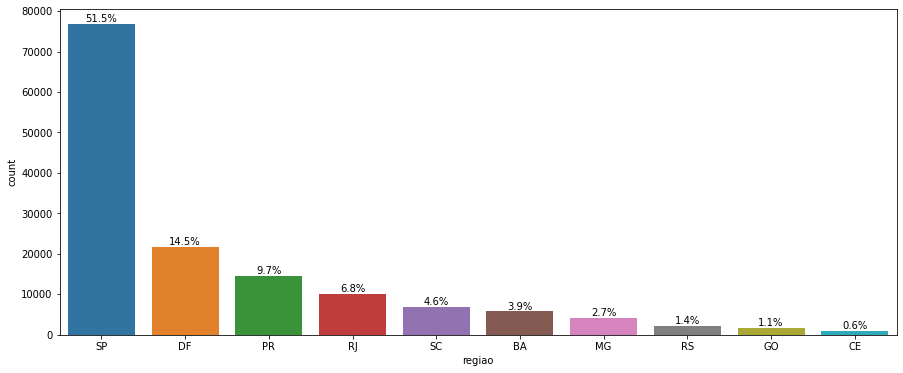

In [40]:
serie_filtrada = df["regiao"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


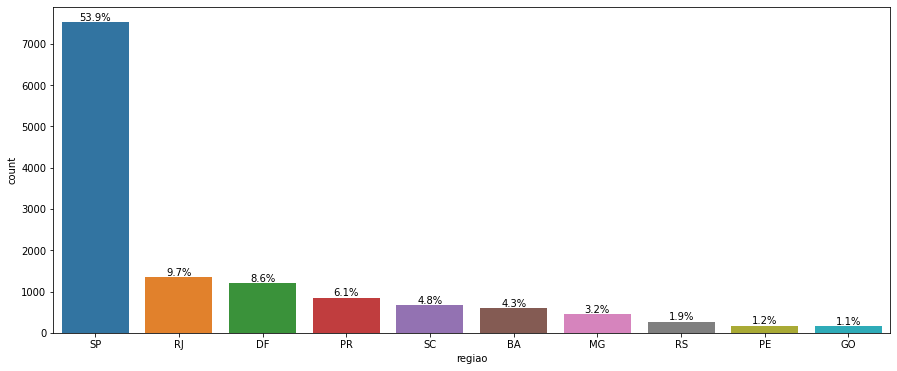

In [41]:
serie_filtrada = df[df["churn"] == 1]["regiao"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Cidade (não aparenta influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


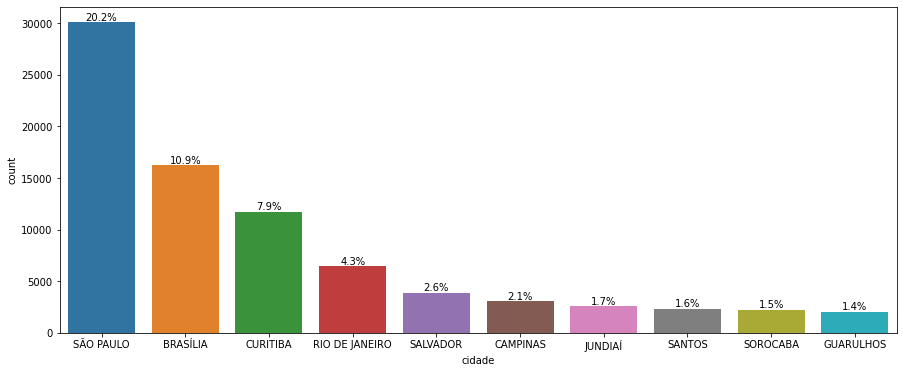

In [42]:
serie_filtrada = df["cidade"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


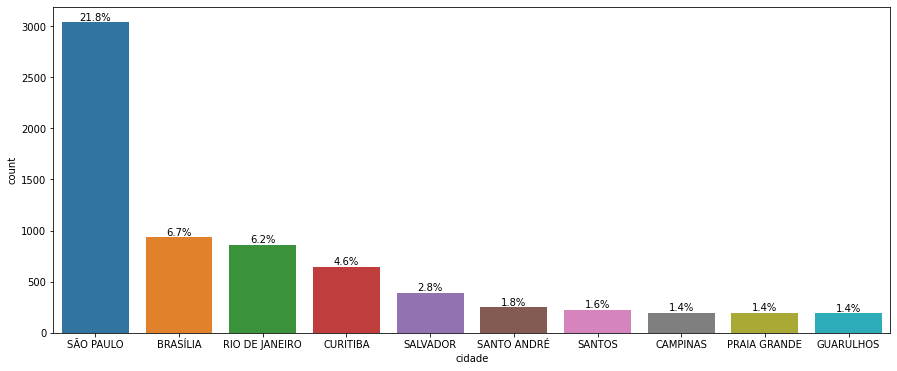

In [43]:
serie_filtrada = df[df["churn"] == 1]["cidade"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Oficina (não aparenta influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


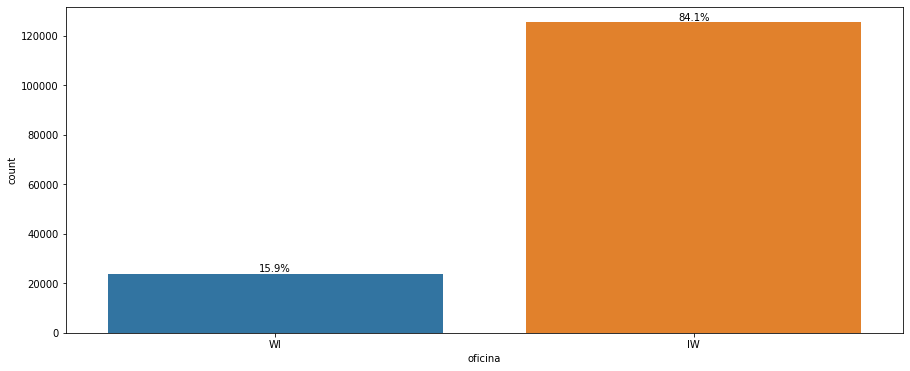

In [44]:
serie_filtrada = df["oficina"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


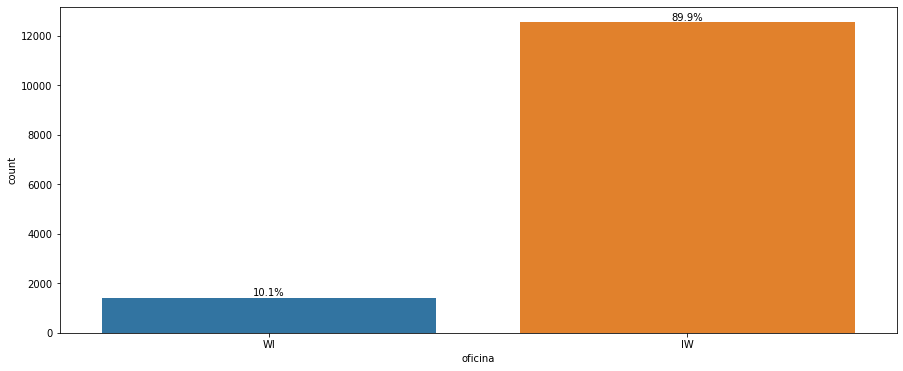

In [45]:
serie_filtrada = df[df["churn"] == 1]["oficina"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Frequência Faturamento (não aparenta influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


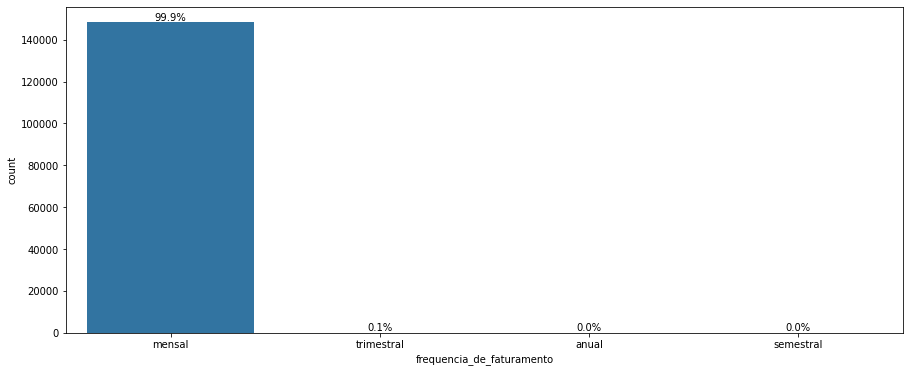

In [46]:
serie_filtrada = df["frequencia_de_faturamento"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


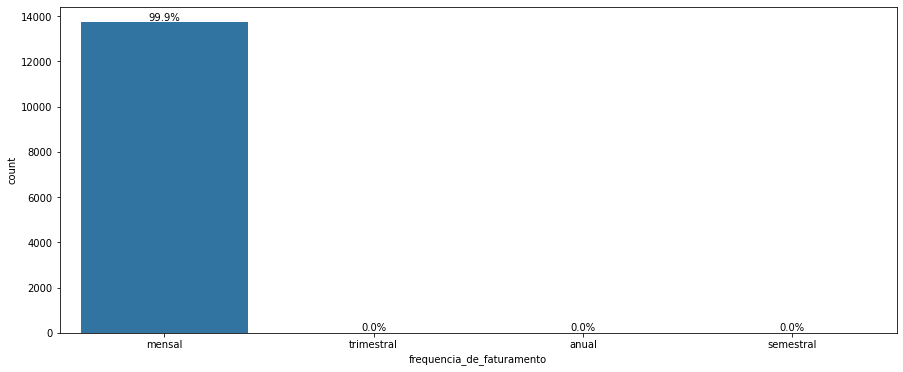

In [47]:
serie_filtrada = df[df["churn"] == 1]["frequencia_de_faturamento"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Tipo de Plano (pode influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


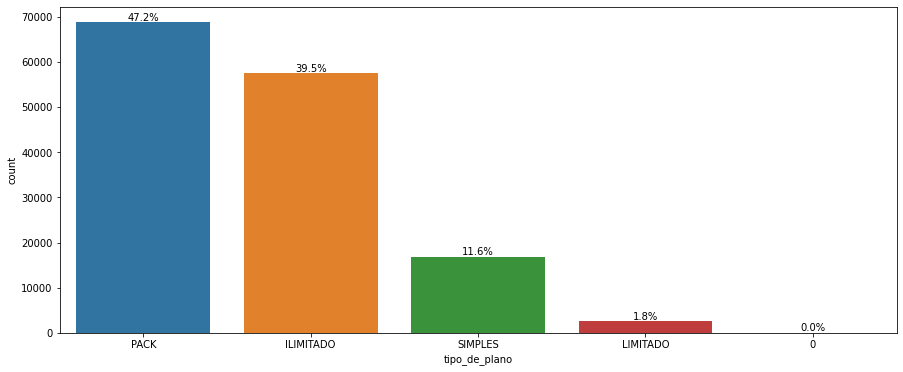

In [48]:
serie_filtrada = df["tipo_de_plano"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


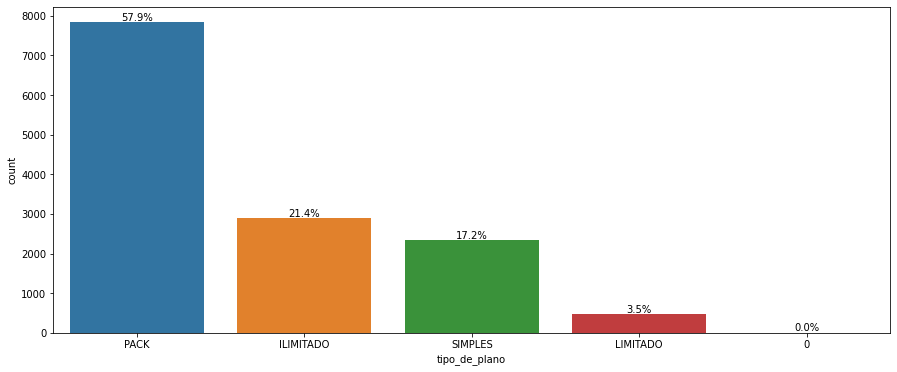

In [49]:
serie_filtrada = df[df["churn"] == 1]["tipo_de_plano"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Executivo Carteira Atual (não aparenta influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


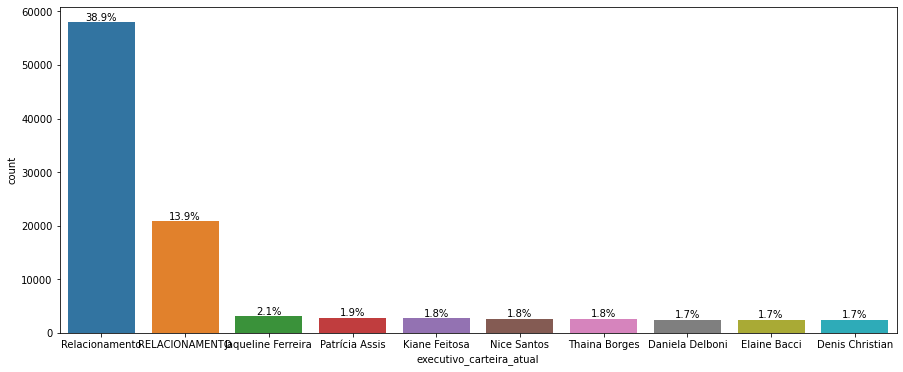

In [50]:
serie_filtrada = df["executivo_carteira_atual"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


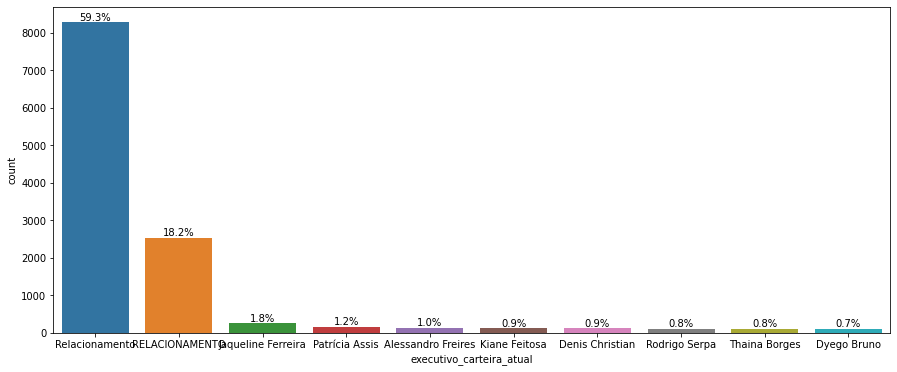

In [51]:
serie_filtrada = df[df["churn"] == 1]["executivo_carteira_atual"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Equipe (pode influenciar no churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


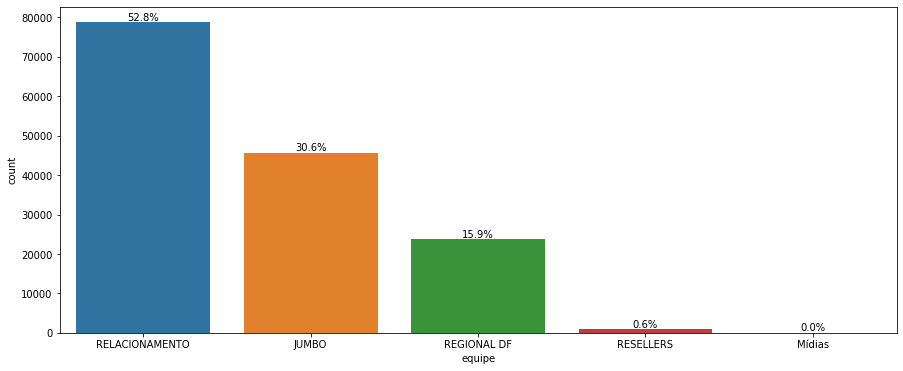

In [52]:
serie_filtrada = df["equipe"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


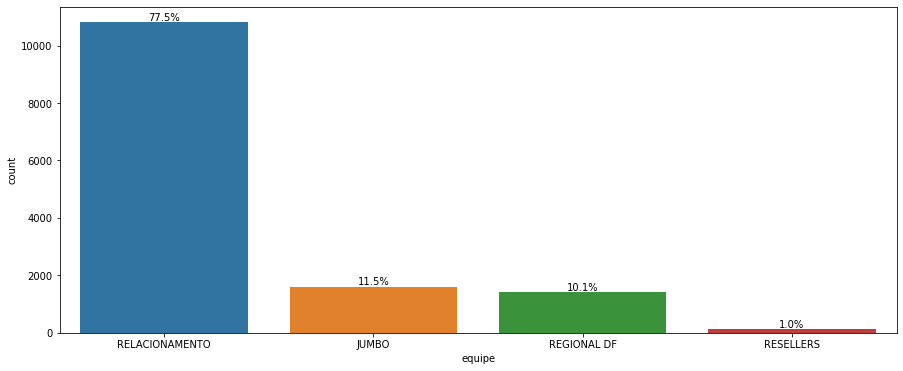

In [53]:
serie_filtrada = df[df["churn"] == 1]["equipe"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Status Final (alta correlação com churn, talvez não seja interessante manter)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


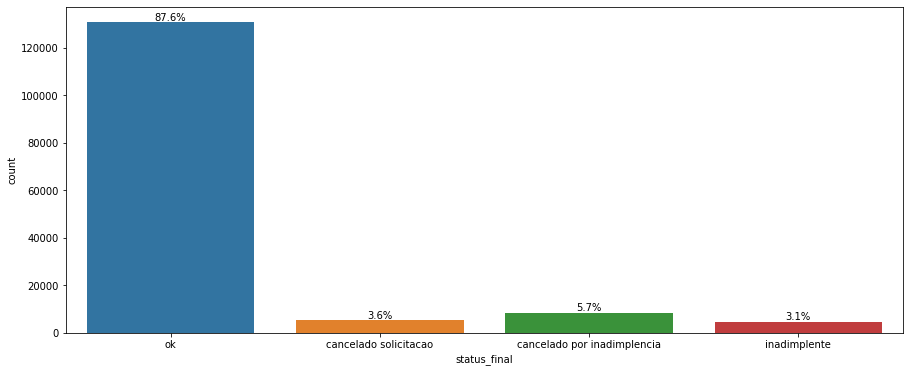

In [54]:
serie_filtrada = df["status_final"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


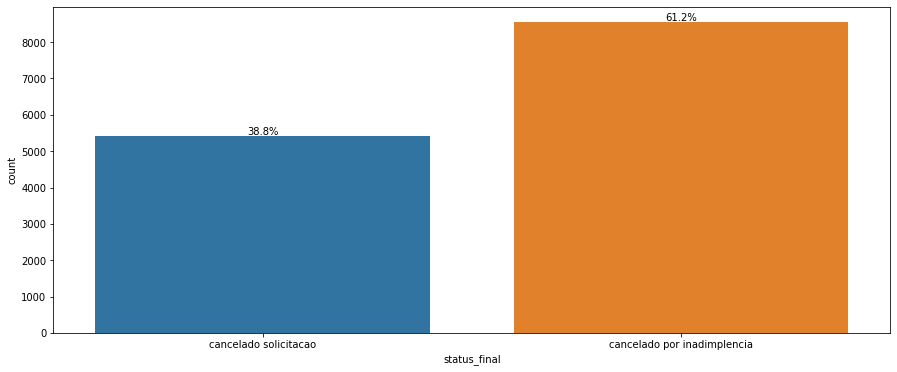

In [55]:
serie_filtrada = df[df["churn"] == 1]["status_final"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Possui Midia Ativa (pode ter influencia no churn, mas muito pouco)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


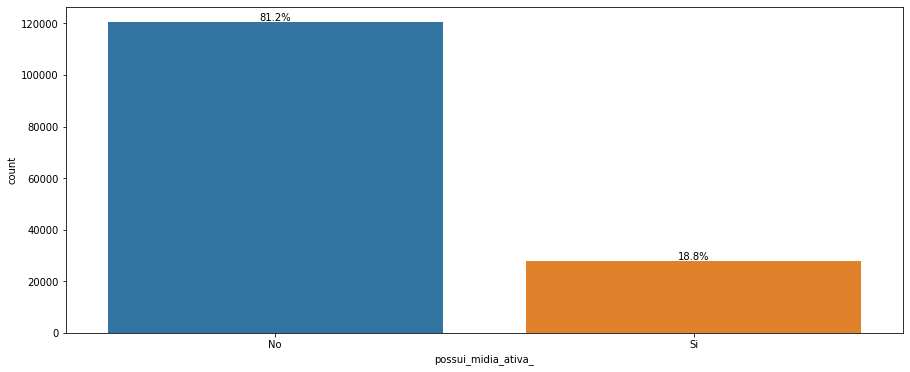

In [56]:
serie_filtrada = df["possui_midia_ativa_"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


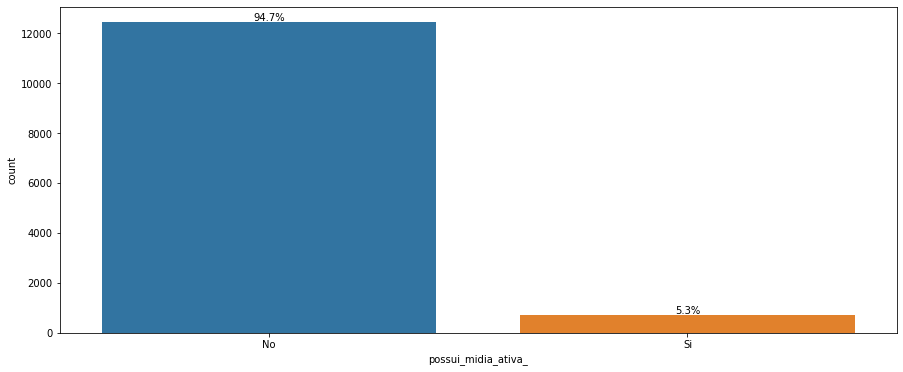

In [57]:
serie_filtrada = df[df["churn"] == 1]["possui_midia_ativa_"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Pessoa Física Jurídica (relação forte com o churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


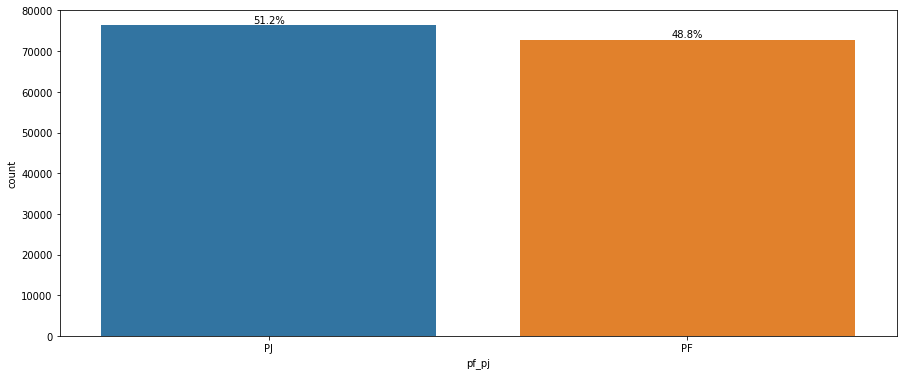

In [58]:
serie_filtrada = df["pf_pj"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


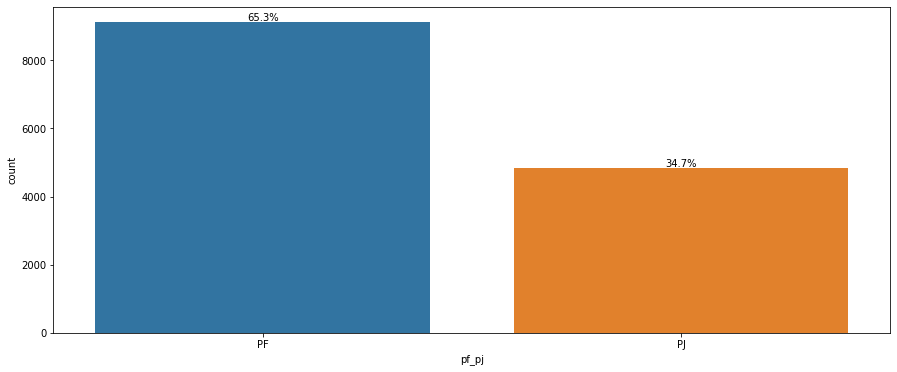

In [59]:
serie_filtrada = df[df["churn"] == 1]["pf_pj"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

### Análise Faixa Listings (relação forte com o churn)

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


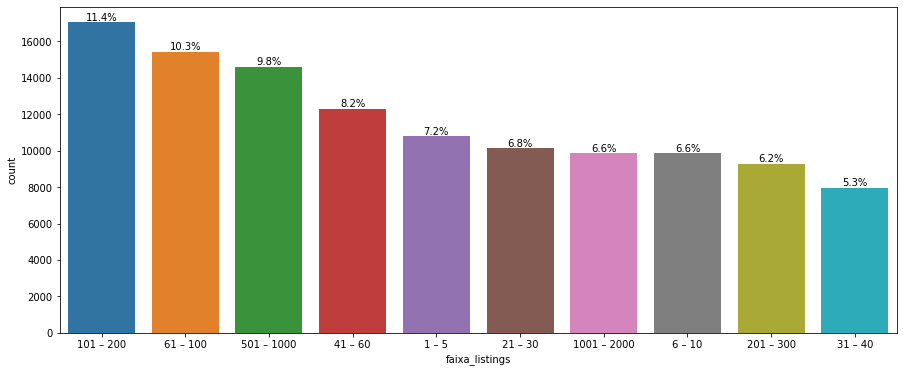

In [60]:
serie_filtrada = df["faixa_listings"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


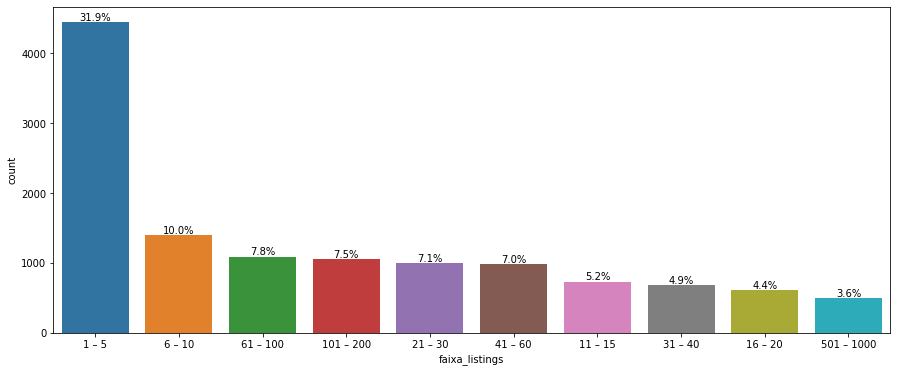

In [61]:
serie_filtrada = df[df["churn"] == 1]["faixa_listings"]

fig, ax = plt.subplots(figsize=(15,6))
g = sns.countplot(serie_filtrada, ax=ax, order=serie_filtrada.value_counts().iloc[:10].index)

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100*y/serie_filtrada.count()), (x.mean(), y), ha='center', va='bottom')

plt.show()

Template

### Análise Valor Mensal (pode influenciar no churn, mas pouco)

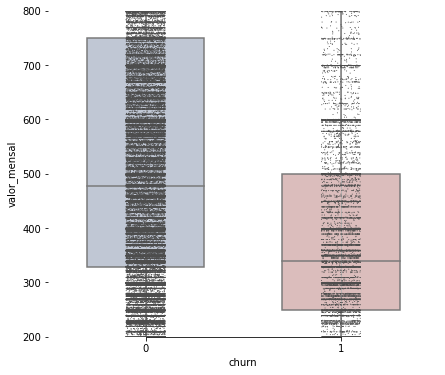

In [62]:
coluna_medida = "valor_mensal"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((200, 800))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Valor Hoje (alta correlação com churn. Talvez seja melhor remover)

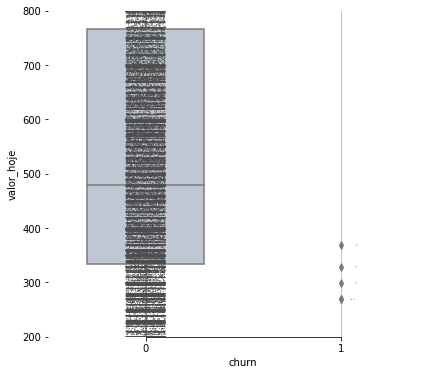

In [63]:
coluna_medida = "valor_hoje"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((200, 800))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Faturamento (Alta correlação com churn. Talvez seja melhor tirar)

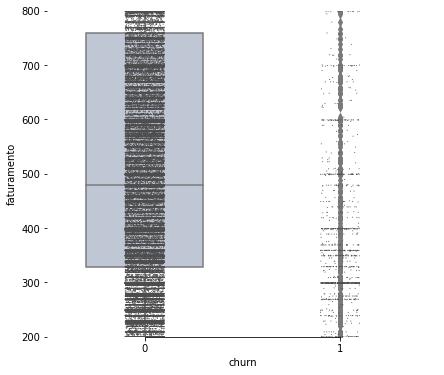

In [64]:
coluna_medida = "faturamento"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((200, 800))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Contratado Super Destaques (pode influenciar no churn)

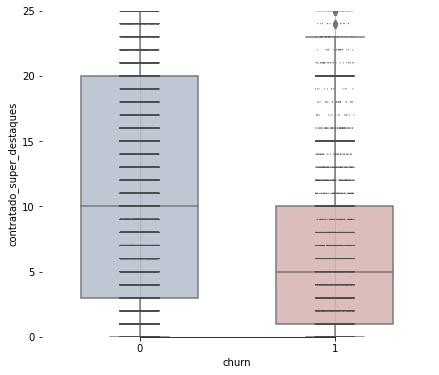

In [65]:
coluna_medida = "contratado_super_destaques"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Contratado Destaques (não aparenta influenciar no churn)

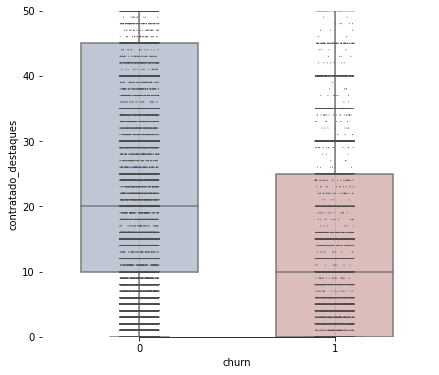

In [66]:
coluna_medida = "contratado_destaques"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 50))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Contratado Ofertas Simples (Relação forte com o churn)

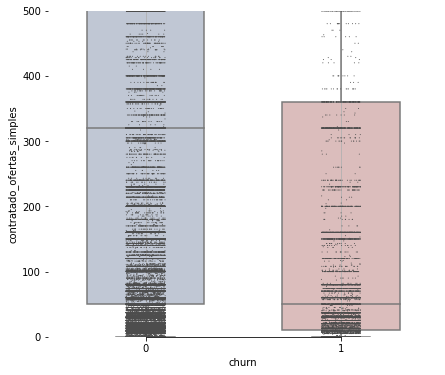

In [67]:
coluna_medida = "contratado_ofertas_simples"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 500))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Utilizado Super Destaque (pode influenciar o churn)

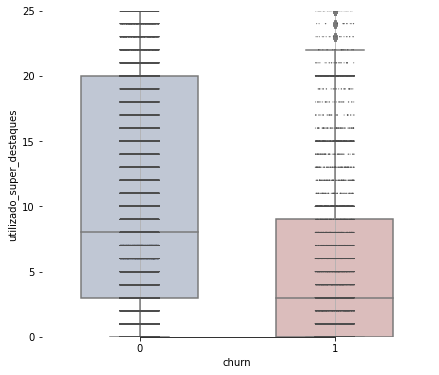

In [68]:
coluna_medida = "utilizado_super_destaques"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Utilizado Destaque (pode influenciar o churn)

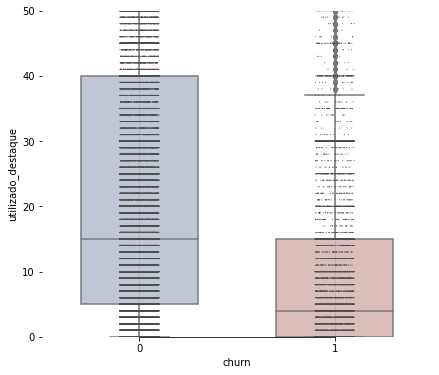

In [69]:
coluna_medida = "utilizado_destaque"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 50))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Utilizado Ofertas Simples (Relação forte com o churn)

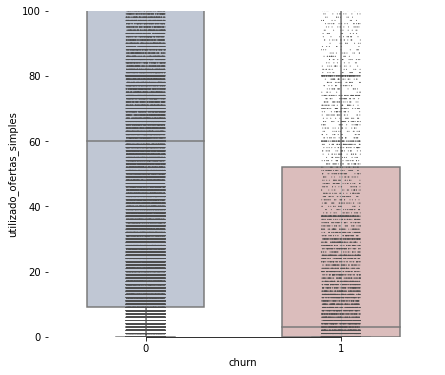

In [70]:
coluna_medida = "utilizado_ofertas_simples"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 100))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Leads Form (Relação forte com o churn)

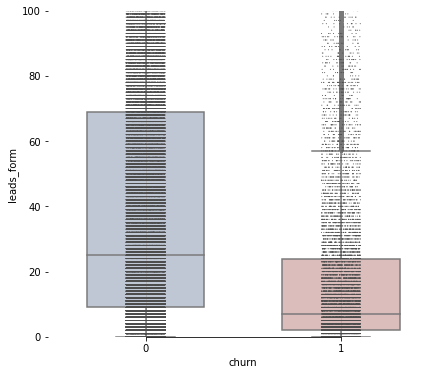

In [71]:
coluna_medida = "leads_form"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 100))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Leads Ver Dato (Relação forte com o churn)

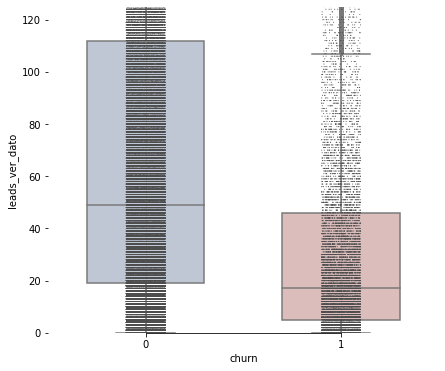

In [72]:
coluna_medida = "leads_ver_dato"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 125))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Leads Total (Relação forte com o churn)

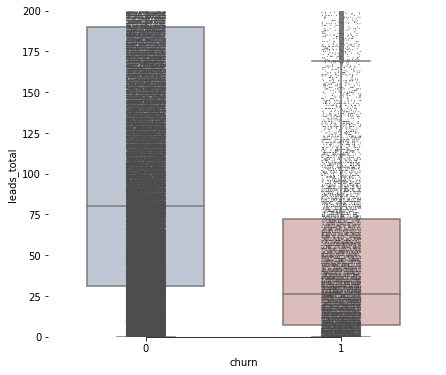

In [73]:
coluna_medida = "leads_total"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 200))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Custo Por Lead Total (Alta correlação com churn. Talvez seja melhor remover)

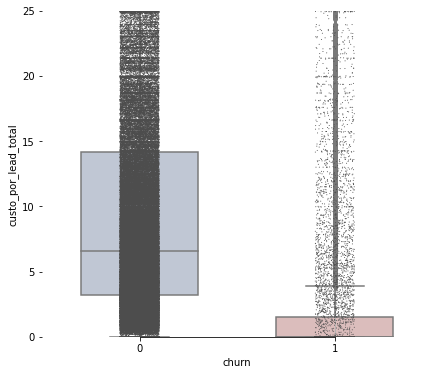

In [74]:
coluna_medida = "custo_por_lead_total"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Total Contratado (Relação fortíssima com o churn)

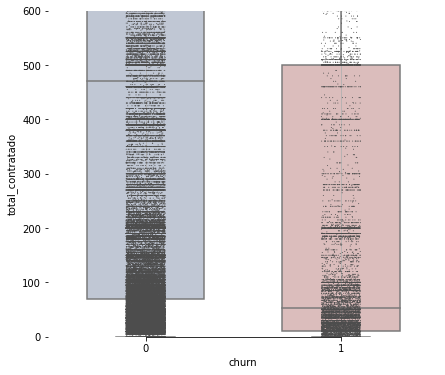

In [75]:
coluna_medida = "total_contratado"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 600))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Total de Listings (Relação forte com o churn)

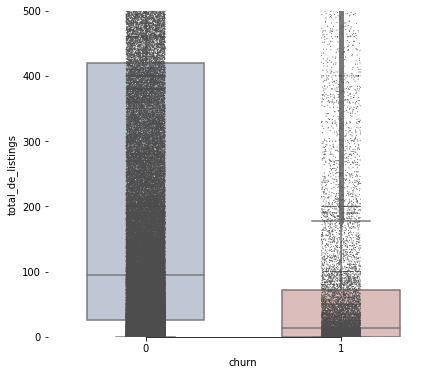

In [76]:
coluna_medida = "total_de_listings"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 500))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True) 

### Análise Custo Por Listing (Alta correlação com churn. Talvez seja melhor remover)

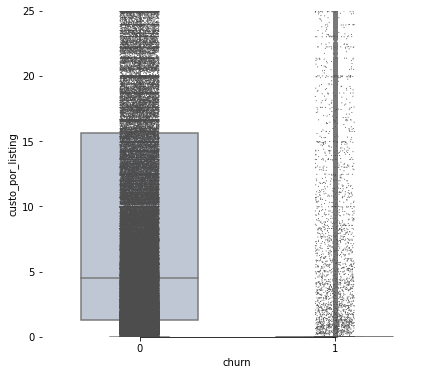

In [77]:
coluna_medida = "custo_por_listing"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 25))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

### Análise Total Utilizado (Relação fortíssima com o churn)

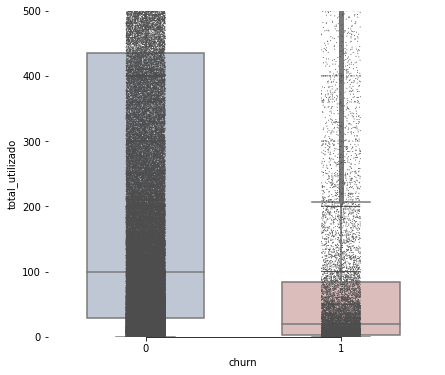

In [78]:
coluna_medida = "total_utilizado"

f, ax = plt.subplots(figsize=(7, 6))
sns.boxplot(x="churn", y=coluna_medida, data=df, width=.6, palette="vlag")
plt.ylim((0, 500))
sns.stripplot(x="churn", y=coluna_medida, data=df, size=1, color=".3", linewidth=0)
ax.xaxis.grid(True)
ax.set(ylabel=coluna_medida)
sns.despine(trim=True, left=True)

# Data Cleaning and Data Wrangling

### Criação de novo dataframe com somente as colunas relevantes

In [79]:
# pode influenciar tanto que talvez seja melhor remover:
# status_final, valor_hoje, faturamento, custo_por_lead_total, custo_por_listing

# pode influenciar muito:
# pf_pj, faixa_listings, contratado_ofertas_simples, utilizado_ofertas_simples,
# leads_form, leads_ver_dato, leads_total, total_contratado, total_de_listings,
# total_utilizado

# pode influenciar:
# tipo_de_plano, equipe, contratado_super_destaques, utilizado_super_destaques, 
# utilizado_destaque

# pode influenciar pouco:
# possui_midia_ativa_, valor_mensal

In [80]:
df = df[['pf_pj', 'contratado_ofertas_simples', 'utilizado_ofertas_simples',
         'leads_form', 'leads_ver_dato', 'total_contratado', 'total_de_listings',
         'total_utilizado', 'equipe', 'contratado_super_destaques', 'utilizado_super_destaques',
         'utilizado_destaque', 'valor_mensal', 'churn']].copy()


### Plot do gráfico de correlação entre variáveis preditoras

<AxesSubplot:>

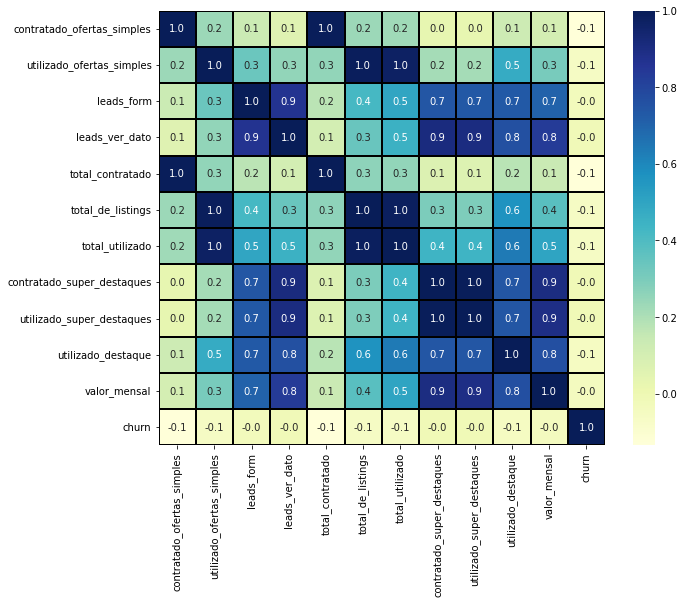

In [81]:
corr = df.corr()

plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='YlGnBu', annot=True, fmt=".1f", linecolor="black", linewidths="0.1", )

# Modeling

### Isolar a variável de churn (target)

In [82]:
dfChurn = df['churn']

### Tratamento das variáveis categóricas

#### Dumificação

In [83]:
df.select_dtypes(include=['object'])


,pf_pj,equipe
0,PJ,REGIONAL DF
1,PF,REGIONAL DF
2,PJ,REGIONAL DF
3,PJ,REGIONAL DF
4,PJ,REGIONAL DF
...,...,...
149183,PJ,REGIONAL DF
149184,PJ,REGIONAL DF
149185,PF,REGIONAL DF
149186,PF,REGIONAL DF


In [84]:
dfCategorical = pd.get_dummies(df.select_dtypes(include=['object']), columns=['pf_pj', 'equipe'])


In [85]:
dfCategorical.head()

,pf_pj_PF,pf_pj_PJ,equipe_JUMBO,equipe_Mídias,equipe_REGIONAL DF,equipe_RELACIONAMENTO,equipe_RESELLERS
0,0,1,0,0,1,0,0
1,1,0,0,0,1,0,0
2,0,1,0,0,1,0,0
3,0,1,0,0,1,0,0
4,0,1,0,0,1,0,0


### Tratamento das variáveis numéricas

In [86]:
dfNumerical = df.select_dtypes(include=np.number).drop(['churn'], axis=1)


#### Tratamento de nulos (substituição por medianas)

In [87]:
dfNumerical.isna().sum()


contratado_ofertas_simples      0
utilizado_ofertas_simples       2
leads_form                     32
leads_ver_dato                 34
total_contratado              535
total_de_listings               0
total_utilizado                 2
contratado_super_destaques      0
utilizado_super_destaques       2
utilizado_destaque              2
valor_mensal                    0
dtype: int64

In [88]:
dfNumerical = dfNumerical.fillna(dfNumerical.median())


In [89]:
dfNumerical.isna().sum()


contratado_ofertas_simples    0
utilizado_ofertas_simples     0
leads_form                    0
leads_ver_dato                0
total_contratado              0
total_de_listings             0
total_utilizado               0
contratado_super_destaques    0
utilizado_super_destaques     0
utilizado_destaque            0
valor_mensal                  0
dtype: int64

### Tratamento de outliers e normalização dos dados

In [90]:
dfNumerical = dfNumerical.copy()
dfNumerical[['contratado_ofertas_simples', 'utilizado_ofertas_simples', 'leads_form', 'leads_ver_dato', 'total_contratado', 'total_de_listings', 'total_utilizado', 'contratado_super_destaques', 'utilizado_super_destaques', 'utilizado_destaque', 'valor_mensal']] = RobustScaler().fit_transform(dfNumerical[['contratado_ofertas_simples', 'utilizado_ofertas_simples', 'leads_form', 'leads_ver_dato',
                                                                                       'total_contratado', 'total_de_listings', 'total_utilizado', 'contratado_super_destaques', 'utilizado_super_destaques', 'utilizado_destaque', 'valor_mensal']])


### Concatenação das variáveis tratadas à variável target

In [91]:
df = pd.concat([dfNumerical, dfCategorical, dfChurn], axis = 1, join='inner')

In [92]:
df.head()


,contratado_ofertas_simples,utilizado_ofertas_simples,leads_form,leads_ver_dato,total_contratado,total_de_listings,total_utilizado,contratado_super_destaques,utilizado_super_destaques,utilizado_destaque,valor_mensal,pf_pj_PF,pf_pj_PJ,equipe_JUMBO,equipe_Mídias,equipe_REGIONAL DF,equipe_RELACIONAMENTO,equipe_RESELLERS,churn
0,-0.021078,-0.135048,-0.035088,0.617978,-0.033106,-0.203343,-0.213904,-0.529412,-0.466667,-0.483871,-0.038797,0,1,0,0,1,0,0,0
1,-0.023587,-0.141479,-0.087719,0.685393,-0.035614,-0.208914,-0.219251,-0.529412,-0.466667,-0.483871,-0.343207,1,0,0,0,1,0,0,0
2,0.977617,-0.048232,2.649123,5.337079,0.968198,-0.041783,-0.058824,-0.470588,-0.400000,0.483871,3.354473,0,1,0,0,1,0,0,0
3,0.977617,0.106109,1.807018,2.921348,0.971108,0.172702,0.147059,1.235294,1.533333,0.483871,8.724415,0,1,0,0,1,0,0,0
4,-0.006022,-0.064309,-0.052632,0.764045,-0.018058,-0.142061,-0.155080,-0.529412,-0.466667,-0.483871,0.286329,0,1,0,0,1,0,0,0


### Testes com algorítmos executados manualmente

#### Divisão do dataset em treino e teste e validação

In [93]:
X = df.drop(['churn'], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train = pd.DataFrame(X_train, columns = X_train.columns)
y_train = pd.Series(y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#### Execução do modelo

In [94]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

param = {
    'eta': 0.3,
    'max_depth': 3,
    'objective': 'multi:softprob',
    'num_class': 3}

steps = 20  # The number of training iterations

modelXG = xgb.train(param, D_train, steps)

modelRF = RandomForestClassifier(n_jobs=-1)
modelRF.fit(X_train, y_train)

modelGB = GradientBoostingClassifier()
modelGB.fit(X_train, y_train)


GradientBoostingClassifier()

#### Resultados do modelo

In [95]:
predictXG = modelXG.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in predictXG])

f1 = round(f1_score(y_test, best_preds, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, best_preds)*100, 2)
precision = round(precision_score(y_test, best_preds)*100, 2)
recall = round(recall_score(y_test, best_preds)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas = {}
metricas["XGBoost"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}


F1 Score: 73.25%
Accuracy Score: 93.41%
Precision Score: 87.86%
Recall Score: 34.97%


F1 Score: 75.02%
Accuracy Score: 93.35%
Precision Score: 78.35%
Recall Score: 40.76%


/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


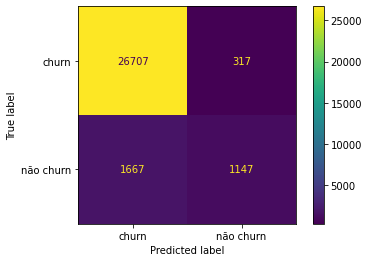

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


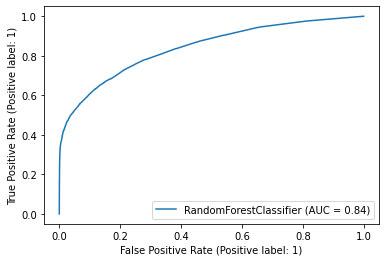

In [96]:
predictRF = modelRF.predict(X_test)

f1 = round(f1_score(y_test, predictRF, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predictRF)*100, 2)
precision = round(precision_score(y_test, predictRF)*100, 2)
recall = round(recall_score(y_test, predictRF)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas["RandomForest"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelRF, X_test, y_test, display_labels=[
                      "churn", "não churn"], values_format="d")
plt.grid(False)
plt.show()

plot_roc_curve(modelRF, X_test, y_test)
plt.show()


F1 Score: 74.94%
Accuracy Score: 93.69%
Precision Score: 88.31%
Recall Score: 38.13%


/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


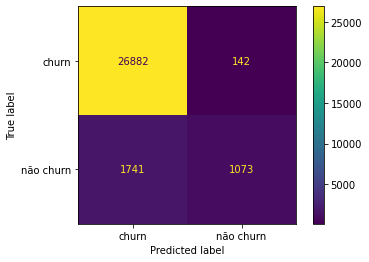

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


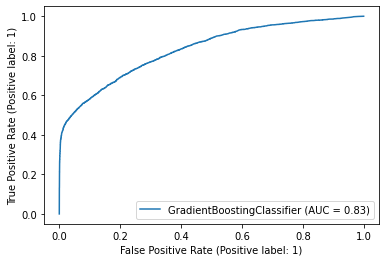

In [97]:
predictGB = modelGB.predict(X_test)

f1 = round(f1_score(y_test, predictGB, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, predictGB)*100, 2)
precision = round(precision_score(y_test, predictGB)*100, 2)
recall = round(recall_score(y_test, predictGB)*100, 2)

print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas["GradientBoosting"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelGB, X_test, y_test, display_labels=[
                      "churn", "não churn"], values_format="d")
plt.grid(False)
plt.show()

plot_roc_curve(modelGB, X_test, y_test)
plt.show()


In [98]:
resumo = pd.DataFrame.from_dict(metricas, orient='index')
resumo


,accuracy,precision,recall,f1
XGBoost,93.41,87.86,34.97,73.25
RandomForest,93.35,78.35,40.76,75.02
GradientBoosting,93.69,88.31,38.13,74.94


### Tunning de hiperparâmetros dos melhores modelos

In [99]:
# parameters = {
#     "n_estimators": [5, 50, 250, 500],
#     "max_depth": [1, 3, 5, 7, 9],
#     "learning_rate": [0.01, 0.1, 1, 10]
# }

# bayes_search = BayesSearchCV(modelGB, search_spaces=parameters, cv=3, n_jobs=-1, verbose=2)
# bayes_search.fit(X_train, y_train)


In [100]:
# bayes_search.best_estimator_
# Results: GradientBoostingClassifier(max_depth=7, n_estimators=50)


F1 Score: 76.31%
Accuracy Score: 94.0%
Precision Score: 91.22%
Recall Score: 40.23%


/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


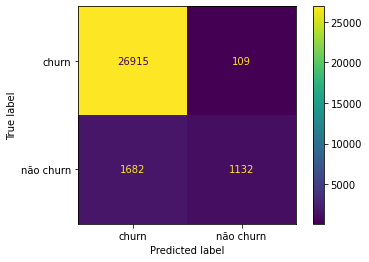

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


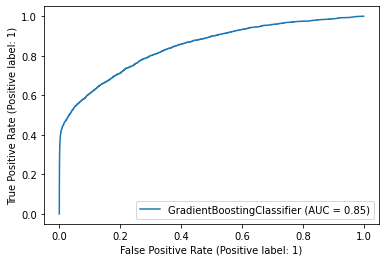

In [101]:
modelGB = GradientBoostingClassifier(max_depth=7, n_estimators=50)
modelGB.fit(X_train, y_train)

y_pred = modelGB.predict(X_test)

f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
precision = round(precision_score(y_test, y_pred)*100, 2)
recall = round(recall_score(y_test, y_pred)*100, 2)


print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas = {}
metricas["GradientBoosting"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelGB, X_test, y_test, display_labels=[
                      "churn", "não churn"], values_format="d")
                      
plt.grid(False)
plt.show()

plot_roc_curve(modelGB, X_test, y_test)
plt.show()


In [102]:
# parametros = {
#     'max_depth': [100, 150],
#     'max_features': [3, 4, 5],
#     'criterion': ['gini', 'entropy'],
#     'min_samples_leaf': [1, 2, 3],
#     'min_samples_split': [2, 3, 8, 10],
#     'n_estimators': [200, 300, 400]
# }

# bayes_search = BayesSearchCV(estimator=modelRF, search_spaces=parametros, n_jobs=-1, cv=3, verbose=2)
# bayes_search.fit(X_train, y_train)


In [103]:
# bayes_search.best_estimator_
# Results: RandomForestClassifier(criterion='entropy', max_depth=150, max_features=5, min_samples_leaf = 2, min_samples_split = 10, n_estimators = 300)


F1 Score: 75.94%
Accuracy Score: 93.93%
Precision Score: 91.01%
Recall Score: 39.55%


/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


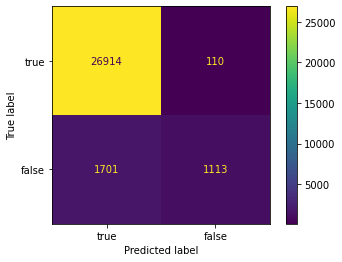

/home/felipe/dev/predicao_churn/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


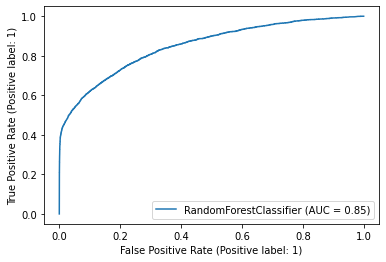

In [104]:
modelRF = RandomForestClassifier(criterion='entropy', max_depth=150, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=300)
modelRF.fit(X_train, y_train)

y_pred = modelRF.predict(X_test)

f1 = round(f1_score(y_test, y_pred, average='macro')*100, 2)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
precision = round(precision_score(y_test, y_pred)*100, 2)
recall = round(recall_score(y_test, y_pred)*100, 2)


print(f"F1 Score: {f1}%")
print(f"Accuracy Score: {accuracy}%")
print(f"Precision Score: {precision}%")
print(f"Recall Score: {recall}%")

metricas["RandomForest"] = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}

plot_confusion_matrix(modelRF, X_test, y_test, display_labels=[
                      "true", "false"], values_format="d")

plt.grid(False)
plt.show()

plot_roc_curve(modelRF, X_test, y_test)
plt.show()


### Definição do melhor modelo

In [105]:
resumo = pd.DataFrame.from_dict(metricas, orient='index')
resumo


,accuracy,precision,recall,f1
GradientBoosting,94.00,91.22,40.23,76.31
RandomForest,93.93,91.01,39.55,75.94


In [106]:
clf = modelGB

### Avaliação da performance do modelo com os dados de validação

In [107]:
y_pred = clf.predict(X_val)

data_set_valid = X_val.reset_index(drop=True)
y_real = pd.Series(y_val).reset_index(drop=True)
y_predito = pd.Series(y_pred, name='churn_predito').reset_index(drop=True)

df_valid = pd.concat([data_set_valid, y_real, y_predito], axis=1)

In [108]:
print('Quantidade total: {}'.format(len(df_valid)))
print('Preditos Corretamente: {}'.format(len(df_valid[df_valid['churn'] == df_valid['churn_predito']])))
print('Preditos Icorretamente: {}'.format(len(df_valid[df_valid['churn'] != df_valid['churn_predito']])))


Quantidade total: 29838
Preditos Corretamente: 27992
Preditos Icorretamente: 1846


### Interpretabilidade individual do resultado dos registros classificados pelo modelo

In [114]:
def predict_explainer(df_fil):
    ''' Apresenta o explain das probabilidades que definiram o registro como "churn" ou não '''
    index_registro_visualizacao = df_fil.sample().index[0]

    print('Quantidade de registros preditos nessa categoria: {}'.format(len(df_fil)))
    print()
    print('-' * 5 + ' Churn Real / Churn Predito ' + '-' * 5)
    print()
    print(df_valid[['churn', 'churn_predito']
                   ].iloc[index_registro_visualizacao])
    print()
    print('-' * 5 + ' Probabilidade ' + '-' * 5)

    explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                                                   feature_names=X_train.columns,
                                                   class_names=[
                                                       "Não Churn", "Churn"],
                                                   mode='classification')

    exp = explainer.explain_instance(X_val.iloc[index_registro_visualizacao],
                                     clf.predict_proba,
                                     num_features=10,
                                     top_labels=1)

    return exp.show_in_notebook(show_table=True, show_all=False)


In [110]:
# Reseta os índices para que possamos procurar os registros

X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)


#### Explain aleatório dos "Churns" considerados "Churn" pelo modelo

In [115]:
df_fil = df_valid[(df_valid['churn'] == df_valid['churn_predito']) & (df_valid['churn'] == 1)]
predict_explainer(df_fil)


Quantidade de registros preditos nessa categoria: 1079

----- Churn Real / Churn Predito -----

churn            1
churn_predito    1
Name: 18756, dtype: int64

----- Probabilidade -----


AttributeError: module 'lime' has no attribute 'lime_tabular'

#### Explain aleatório dos "Não Churns" considerados "Não Churn" pelo modelo

In [ ]:
df_fil = df_valid[(df_valid['churn'] == df_valid['churn_predito']) & (df_valid['churn'] == 0)]
predict_explainer(df_fil)


#### Explain aleatório dos "Churns" considerados "Não Churn"

In [ ]:
df_fil = df_valid[(df_valid['churn'] != df_valid['churn_predito']) & (df_valid['churn'] == 1)]
predict_explainer(df_fil)

#### Explain aleatório dos "Não Churn" considerados "Churn"

In [ ]:
df_fil = df_valid[(df_valid['churn'] != df_valid['churn_predito']) & (df_valid['churn'] == 0)]
predict_explainer(df_fil)